In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import requests
import zipfile
import shutil

In [2]:
DATA_DIR = "/data/krf/dataset/ChinaSet_AllFiles/CXR_png"
MASK_DIR = "/data/krf/dataset/mask"
ROOT_DIR = "/data/krf/model/rsna"

In [3]:
IMG_SIZE = 256
def loadDataset():
    image_fp = os.listdir(DATA_DIR)
    image_fp.sort()
    images = []
    for img_nm in image_fp:
        tmp = cv2.imread(os.path.join(DATA_DIR,img_nm))
        b,g,r = cv2.split(tmp)
        res = cv2.resize(b,(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype(np.uint8)
        images.append(res[:,:,np.newaxis])
    images = np.asarray(images)
    print(images.shape)
    mask_fp = os.listdir(MASK_DIR)
    mask_fp.sort()
    masks = []
    for msk_nm in mask_fp:
        tmp = cv2.imread(os.path.join(MASK_DIR,msk_nm))
        b,g,r = cv2.split(tmp)
        res = cv2.resize(b,(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype(np.bool)
        masks.append(res[:,:,np.newaxis])
    masks = np.asarray(masks)
    print(masks.shape)
    return images,masks

In [4]:
%%time
images,masks = loadDataset()

(566, 256, 256, 1)
(566, 256, 256, 1)
CPU times: user 3min 29s, sys: 10.2 s, total: 3min 39s
Wall time: 3min 50s


In [5]:
#delete some image without mask file
# image_fp = os.listdir(DATA_DIR)
# image_fp.sort()
# mask_fp = os.listdir(MASK_DIR)
# mask_fp.sort()
# j = 0
# for i in range(len(image_fp)):
#     #print(mask_fp[j][:-9],image_fp[i][:-4])
#     if mask_fp[j][:-9] != image_fp[i][:-4]:
#         print(image_fp[i])
#         os.remove(os.path.join(DATA_DIR,image_fp[i]))
#         i += 1
#         j -= 1
#     j+=1


(256, 256, 1)
[[[ 96]
  [ 60]
  [ 45]
  ...
  [ 85]
  [ 87]
  [ 91]]

 [[ 93]
  [ 57]
  [ 43]
  ...
  [ 80]
  [ 83]
  [ 87]]

 [[ 92]
  [ 56]
  [ 39]
  ...
  [ 77]
  [ 79]
  [ 85]]

 ...

 [[132]
  [129]
  [127]
  ...
  [ 80]
  [ 84]
  [ 92]]

 [[  0]
  [  0]
  [  0]
  ...
  [112]
  [114]
  [118]]

 [[  0]
  [  0]
  [  0]
  ...
  [ 78]
  [ 80]
  [ 80]]]
(256, 256, 1)
[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]


(-0.5, 255.5, 255.5, -0.5)

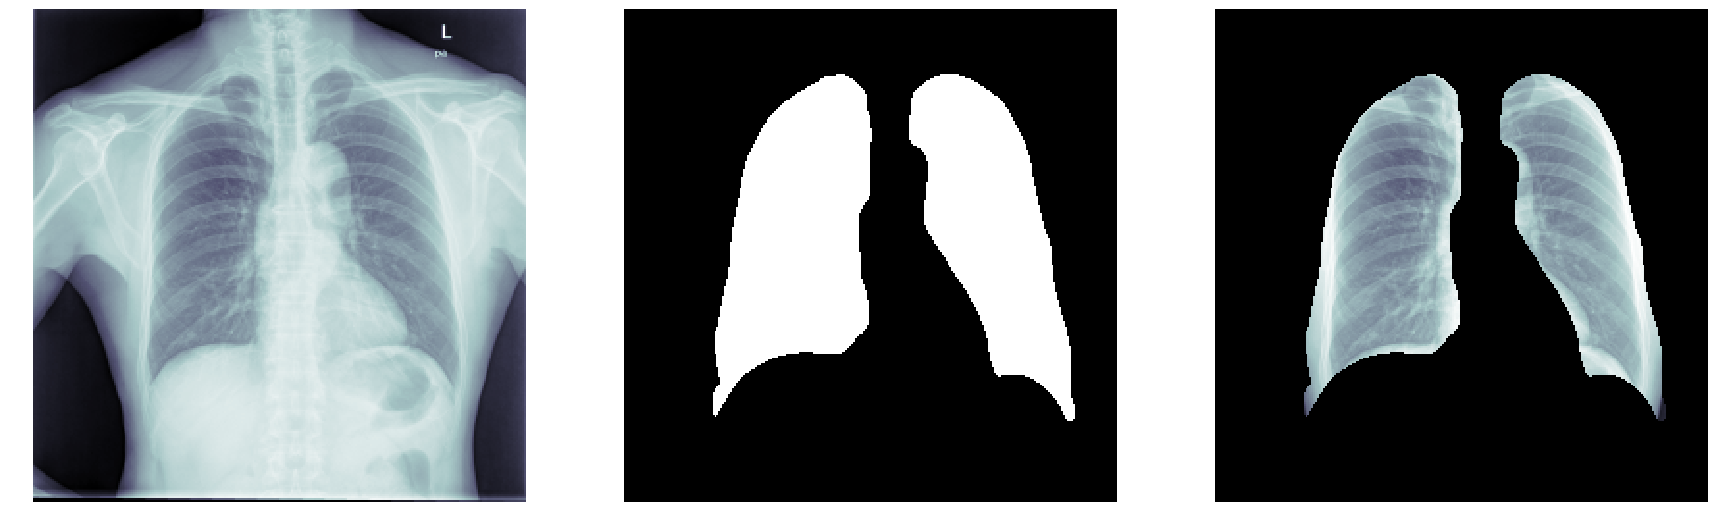

In [33]:
img_index = 3
print(images[img_index].shape)
print(images[img_index])
print(masks[img_index].shape)
print(masks[img_index])
plt.figure(figsize=(30, 20))
plt.subplot(1,3,1)
plt.imshow(images[img_index,:,:,0], cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(masks[img_index,:,:,0], cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cv2.bitwise_and(images[img_index,:,:,0], images[img_index,:,:,0], 
                           mask=masks[img_index,:,:,0].astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')

In [7]:
# download MD.ai's dilated unet implementation 
# UNET_URL = 'https://s3.amazonaws.com/md.ai-ml-lessons/unet.zip'
# UNET_ZIPPED = 'unet.zip'

# if not os.path.exists(UNET_ZIPPED): 
#     r = requests.get(UNET_URL, stream=True)
#     if r.status_code == requests.codes.ok:
#         with open(UNET_ZIPPED, "wb") as f:
#             shutil.copyfileobj(r.raw, f)
#     else:
#         r.raise_for_status()

# with zipfile.ZipFile(UNET_ZIPPED) as zf:
#     zf.extractall()

In [8]:
from unet import dataset
from unet import dilated_unet
from unet import train

Using TensorFlow backend.


/data/krf/model/rsna/unet


In [9]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

CONFIG_FP = 'unet/configs/krf.json'
name = os.path.basename(CONFIG_FP).split('.')[0]
print(name)

krf


In [10]:
import json
with open(CONFIG_FP,'r') as f:
    config = json.load(f)

In [11]:
history = train.train(config,name,images,masks,num_epochs = 50)

Epoch 1/50
 - 52s - loss: 0.2371 - acc: 0.9154 - dice: 0.8192 - iou: 0.7148 - val_loss: 0.3380 - val_acc: 0.8807 - val_dice: 0.7809 - val_iou: 0.7856

Epoch 00001: val_loss improved from inf to 0.33796, saving model to /data/krf/model/rsna/unet/trained/model_krf.hdf5
Epoch 2/50
 - 43s - loss: 0.1263 - acc: 0.9572 - dice: 0.9011 - iou: 0.8188 - val_loss: 0.2740 - val_acc: 0.8985 - val_dice: 0.8018 - val_iou: 0.7359

Epoch 00002: val_loss improved from 0.33796 to 0.27403, saving model to /data/krf/model/rsna/unet/trained/model_krf.hdf5
Epoch 3/50
 - 45s - loss: 0.0985 - acc: 0.9653 - dice: 0.9229 - iou: 0.8529 - val_loss: 0.0859 - val_acc: 0.9707 - val_dice: 0.9423 - val_iou: 0.9090

Epoch 00003: val_loss improved from 0.27403 to 0.08594, saving model to /data/krf/model/rsna/unet/trained/model_krf.hdf5
Epoch 4/50
 - 45s - loss: 0.0815 - acc: 0.9713 - dice: 0.9344 - iou: 0.8717 - val_loss: 0.1199 - val_acc: 0.9574 - val_dice: 0.9168 - val_iou: 0.9148

Epoch 00004: val_loss did not improve

dict_keys(['val_iou', 'dice', 'val_acc', 'val_dice', 'val_loss', 'loss', 'iou', 'acc'])


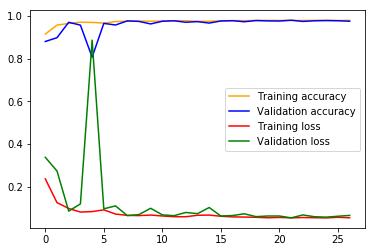

In [12]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

In [13]:
from keras.models import load_model
import keras.backend as K

model_name = 'unet/trained/model_'+name+'.hdf5'
print(model_name)
model = load_model(model_name, custom_objects={'dice': train.dice, 'iou': train.iou})

unet/trained/model_krf.hdf5


(1, 256, 256, 1)
[[[ 91]
  [ 59]
  [ 51]
  ...
  [ 88]
  [ 91]
  [ 95]]

 [[ 88]
  [ 56]
  [ 49]
  ...
  [ 84]
  [ 87]
  [ 91]]

 [[ 87]
  [ 53]
  [ 45]
  ...
  [ 81]
  [ 84]
  [ 88]]

 ...

 [[  0]
  [  0]
  [  0]
  ...
  [182]
  [188]
  [197]]

 [[  0]
  [  0]
  [  0]
  ...
  [204]
  [208]
  [208]]

 [[  0]
  [  0]
  [  0]
  ...
  [124]
  [125]
  [125]]]
(256, 256)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


Text(0.5, 1.0, 'Predicted Lung Segmentation')

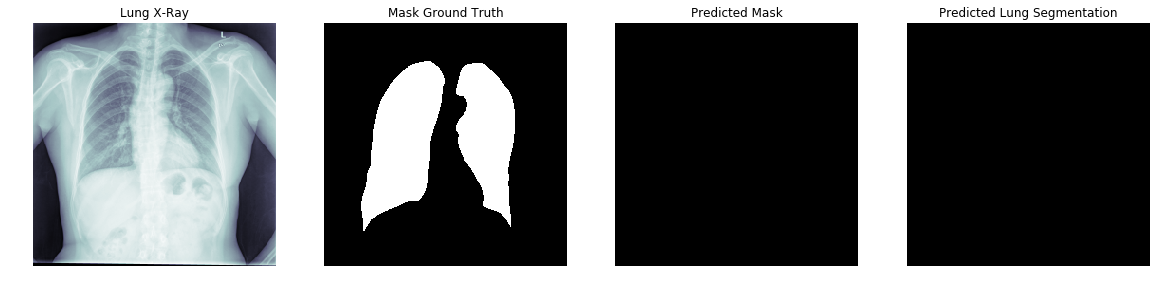

In [34]:
#images, masks = dataset.load_images(imgs_anns_dict)
import random
plt.figure(figsize=(20, 10))

img_index = random.choice(range(len(images)))

plt.subplot(1,4,1)
random_img = images[img_index,:,:,0]
plt.imshow(random_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Lung X-Ray')

plt.subplot(1,4,2)
random_mask = masks[img_index,:,:,0]
plt.imshow(random_mask, cmap=plt.cm.bone)
plt.axis('off')

plt.title('Mask Ground Truth')

#random_img_2 = np.expand_dims(np.expand_dims(random_img, axis=0), axis=3)

print(random_img_2.shape)
print(random_img_2[0])
mask = model.predict(random_img_2)[0][:,:,0] > 0.5
#mask = model.predict(random_img_2)
print(mask.shape)
print(mask)
plt.subplot(1,4,3)
plt.imshow(mask, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Mask')

plt.subplot(1,4,4)
plt.imshow(cv2.bitwise_and(random_img, random_img, mask=mask.astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Lung Segmentation')

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(20, 256, 256, 1)
[[[35]
  [13]
  [ 6]
  ...
  [28]
  [31]
  [33]]

 [[34]
  [11]
  [ 5]
  ...
  [24]
  [28]
  [31]]

 [[33]
  [11]
  [ 5]
  ...
  [22]
  [24]
  [28]]

 ...

 [[11]
  [10]
  [10]
  ...
  [39]
  [40]
  [44]]

 [[ 0]
  [ 0]
  [ 0]
  ...
  [63]
  [64]
  [66]]

 [[ 0]
  [ 0]
  [ 0]
  ...
  [49]
  [49]
  [51]]]
(20, 256, 256, 1)
[[[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  ...

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
 

Text(0.5, 1.0, 'Predicted Lung Segmentation')

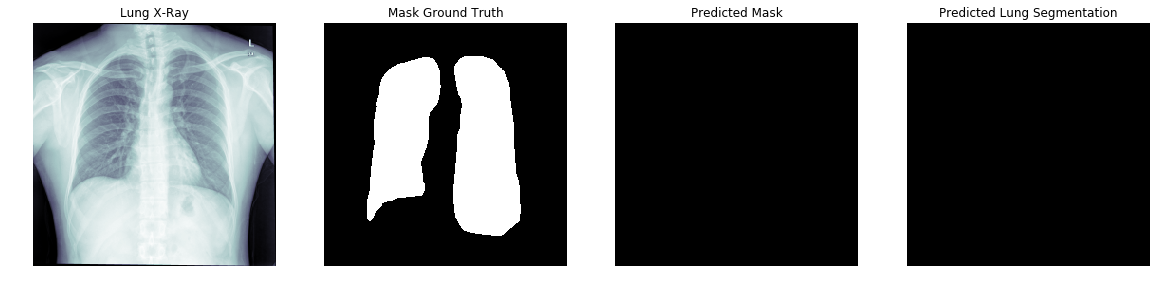

In [39]:
#images, masks = dataset.load_images(imgs_anns_dict)

plt.figure(figsize=(20, 10))

img_index = random.choice(range(20))

plt.subplot(1,4,1)
random_img = images[img_index,:,:,0]
plt.imshow(random_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Lung X-Ray')

plt.subplot(1,4,2)
random_mask = masks[img_index,:,:,0]
print(random_mask)
plt.imshow(random_mask, cmap=plt.cm.bone)
plt.axis('off')

plt.title('Mask Ground Truth')

#random_img_2 = np.expand_dims(np.expand_dims(random_img, axis=0), axis=3)
tests = images[:20]

print(tests.shape)
print(tests[0])
results = model.predict(tests) > 0.5
#mask = model.predict(random_img_2)
print(results.shape)
print(results)
mask = results[img_index,:,:,0]
print(mask)
plt.subplot(1,4,3)
plt.imshow(mask, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Mask')

plt.subplot(1,4,4)
plt.imshow(cv2.bitwise_and(random_img, random_img, mask=mask.astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Lung Segmentation')